In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision.transforms as transforms
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split

pd.set_option("display.max_columns", None)
np.random.seed(42)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
import sys
sys.path.append('./BGR')
import bgr.datasets as bgr_data
import bgr.models as bgr_mod

In [3]:
path_csv = "../data/BGR/data_horizons.csv"
path_csv_annotator_ids = '../data/BGR/Kartierer_ID.csv'
path_csv_locations = '../data/BGR/STANDORT.csv'
path_horizons_simple = '../data/BGR/Vereinfachung_Horizontsymbole.csv'
#path_pictures = "/Users/felix/Library/CloudStorage/Dropbox/data/BGR-Data-Bodenhorizonte/Profilbilder/"
path_pictures = "../data/BGR/Profilbilder_no_ruler/"

In [4]:
df = pd.read_csv(path_csv)
print(len(df.index))
df = df.dropna(subset=['Bodenart'])
print(len(df.index))
df#.head()

15207
15151


,Point,HorizontID,Obergrenze,Untergrenze,Horizontsymbol,Bodenart,Bodenfarbe,Steine,Karbonat,Humusgehaltsklasse,Durchwurzelung,Unnamed: 11,Bundesland,PointID,Unnamed: 14,profile,max_depth
0,2.0,1.0,0.0,28.0,I; Ap,Sl2,7.5YR 3/2,3.0,C0,h3,Wf4,NaN,SH,2.0,NaN,BB_0541.0,100.0
1,2.0,2.0,28.0,54.0,I; E,Sl2,10YR 3/3,3.0,C0,h2,Wf3,NaN,SH,3.0,NaN,BB_0600.0,90.0
2,2.0,3.0,54.0,68.0,II; Bv,Sl2,7.5YR 4/3,10.0,C0,h1,Wf3,NaN,SH,4.0,NaN,BB_0601.0,100.0
3,2.0,4.0,68.0,96.0,III; Bv-ilCv,fSms,7.5YR 6/4,1.0,C0,h0,Wf2,NaN,SH,5.0,NaN,BB_0659.0,100.0
4,2.0,5.0,96.0,201.0,III; ilCv,mSfs,10YR 7/4,1.0,C0,h0,NaN,NaN,SH,6.0,NaN,BB_0660.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15201,6211.0,3.0,27.0,50.0,I; Bbh+Bs,fSms,5YR 3/2,1.0,C0,h2,Wf3,NaN,NaN,NaN,NaN,NaN,NaN
15202,6211.0,4.0,50.0,70.0,I; Bbs+Bs,fSms,5YR 4/3,1.0,C0,h1,Wf2,NaN,NaN,NaN,NaN,NaN,NaN
15203,6211.0,5.0,70.0,100.0,I; Go-Bbs,fSms,7.5YR 5/4,1.0,C0,h1,Wf6,NaN,NaN,NaN,NaN,NaN,NaN
15204,6211.0,6.0,100.0,130.0,I; Go,fSms,2.5Y 6/4,1.0,C0,h0,Wf4,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df_simple = pd.read_csv(path_horizons_simple)
df_simple.head()

,Horiz,Anzahl im Datensatz,relevanter Anteil = was sinntragend und detektierbar ist - es sind nicht alles gültige Symbole,stark vereinfacht
0,Ap,1762,Ap,Ap
1,Bv,626,Bv,Bv
2,ilCv,620,ilC,Cv
3,elCv,500,elC,Cv
4,Ah,455,Ah,Ah


In [6]:
# Add an extra column to the original dataset with the simplified horizon symbols

# Apply the simplification function to each row of the 'Horizontsymbol' column
df['Horizontsymbol_einfach'] = df['Horizontsymbol'].apply(lambda x: bgr_data.simplify_string(x, df_simple))

# Reorder the columns
cols = df.columns.tolist()
cols.insert(cols.index('Horizontsymbol') + 1, 'Horizontsymbol_einfach')
cols.pop() # remove the duplicate at the end
df = df[cols]
df

,Point,HorizontID,Obergrenze,Untergrenze,Horizontsymbol,Horizontsymbol_einfach,Bodenart,Bodenfarbe,Steine,Karbonat,Humusgehaltsklasse,Durchwurzelung,Unnamed: 11,Bundesland,PointID,Unnamed: 14,profile,max_depth
0,2.0,1.0,0.0,28.0,I; Ap,Ap,Sl2,7.5YR 3/2,3.0,C0,h3,Wf4,NaN,SH,2.0,NaN,BB_0541.0,100.0
1,2.0,2.0,28.0,54.0,I; E,E,Sl2,10YR 3/3,3.0,C0,h2,Wf3,NaN,SH,3.0,NaN,BB_0600.0,90.0
2,2.0,3.0,54.0,68.0,II; Bv,Bv,Sl2,7.5YR 4/3,10.0,C0,h1,Wf3,NaN,SH,4.0,NaN,BB_0601.0,100.0
3,2.0,4.0,68.0,96.0,III; Bv-ilCv,Bv-Cv,fSms,7.5YR 6/4,1.0,C0,h0,Wf2,NaN,SH,5.0,NaN,BB_0659.0,100.0
4,2.0,5.0,96.0,201.0,III; ilCv,Cv,mSfs,10YR 7/4,1.0,C0,h0,NaN,NaN,SH,6.0,NaN,BB_0660.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15201,6211.0,3.0,27.0,50.0,I; Bbh+Bs,Bbh+Bs,fSms,5YR 3/2,1.0,C0,h2,Wf3,NaN,NaN,NaN,NaN,NaN,NaN
15202,6211.0,4.0,50.0,70.0,I; Bbs+Bs,Bbs+Bs,fSms,5YR 4/3,1.0,C0,h1,Wf2,NaN,NaN,NaN,NaN,NaN,NaN
15203,6211.0,5.0,70.0,100.0,I; Go-Bbs,Go-Bbs,fSms,7.5YR 5/4,1.0,C0,h1,Wf6,NaN,NaN,NaN,NaN,NaN,NaN
15204,6211.0,6.0,100.0,130.0,I; Go,Go,fSms,2.5Y 6/4,1.0,C0,h0,Wf4,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
image_dataset = os.listdir(path_pictures)
img_files = pd.DataFrame(image_dataset, columns=['file'])
img_files['Point'] = img_files['file'].str.split("_").map(lambda x: x[1]).astype(float)
img_files.head()

,file,Point
0,BB_0896_Y_1.JPG,896.0
1,BB_0903_Y_1.JPG,903.0
2,BW_4930_Y_1.JPG,4930.0
3,BW_5183_Y_1.JPG,5183.0
4,BW_5462_Y_1.JPG,5462.0


In [8]:
df = pd.merge(df, img_files, how='inner', on='Point')
df['file'] = df['file'].map(lambda x: os.path.join(path_pictures, x))
df.head()

,Point,HorizontID,Obergrenze,Untergrenze,Horizontsymbol,Horizontsymbol_einfach,Bodenart,Bodenfarbe,Steine,Karbonat,Humusgehaltsklasse,Durchwurzelung,Unnamed: 11,Bundesland,PointID,Unnamed: 14,profile,max_depth,file
0,2.0,1.0,0.0,28.0,I; Ap,Ap,Sl2,7.5YR 3/2,3.0,C0,h3,Wf4,NaN,SH,2.0,NaN,BB_0541.0,100.0,../data/BGR/Profilbilder_no_ruler/SH_0002_Y_1.JPG
1,2.0,2.0,28.0,54.0,I; E,E,Sl2,10YR 3/3,3.0,C0,h2,Wf3,NaN,SH,3.0,NaN,BB_0600.0,90.0,../data/BGR/Profilbilder_no_ruler/SH_0002_Y_1.JPG
2,2.0,3.0,54.0,68.0,II; Bv,Bv,Sl2,7.5YR 4/3,10.0,C0,h1,Wf3,NaN,SH,4.0,NaN,BB_0601.0,100.0,../data/BGR/Profilbilder_no_ruler/SH_0002_Y_1.JPG
3,2.0,4.0,68.0,96.0,III; Bv-ilCv,Bv-Cv,fSms,7.5YR 6/4,1.0,C0,h0,Wf2,NaN,SH,5.0,NaN,BB_0659.0,100.0,../data/BGR/Profilbilder_no_ruler/SH_0002_Y_1.JPG
4,2.0,5.0,96.0,201.0,III; ilCv,Cv,mSfs,10YR 7/4,1.0,C0,h0,NaN,NaN,SH,6.0,NaN,BB_0660.0,100.0,../data/BGR/Profilbilder_no_ruler/SH_0002_Y_1.JPG


In [9]:
df_k = pd.read_csv(path_csv_annotator_ids)
df_k = df_k.rename({'PointID':'Point'},axis=1)
df_k.head()

,Point,Aufnehmer
0,2,Kart8
1,3,Kart8
2,4,Kart10
3,5,Kart8
4,6,Kart8


In [10]:
df_loc = pd.read_csv(path_csv_locations, encoding='unicode_escape')
df_loc = df_loc.rename({'PointID':'Point'},axis=1)
df_loc.head()

,Point,Bundesland,Probenahme_Monat,Probenahme_Jahr,xcoord,ycoord,Bodenklimaraum_Name,Landnutzung,BZE_Moor,Hauptbodentyp,BodenVarTypSub,GrundwaStufe,GrundwaStand,Moormaechtigkeit,Torfmaechtigkeit,Neigung,Exposition,Woelbung,Reliefformtyp,LageImRelief,KV_0_30,KV_30_100
0,2,SH,11,2015,462216.1283,6079359.775,Marsch - Nord,A,0,YE,YE/BB,0,>200,0.0,0.0,N0,NaN,GG,V,Z,81.89,54.19
1,3,SH,6,2016,480546.9384,6079739.216,Marsch - Nord,G,0,MD,MDn,GWS4,135,0.0,0.0,N0,NaN,GG,TSF,Z,71.62,59.74
2,4,SH,8,2018,484922.3074,6080011.471,Marsch - Nord,A,0,MK,MKn,GWS4,105,0.0,0.0,N1,NE,GG,TH,Z,65.60,120.40
3,5,SH,10,2015,497355.9905,6079646.589,Marsch - Nord,G,0,RQ,p2RQ/GG-PP,GWS4,180,0.0,0.0,N0.2,SS,GG,KSF,K,88.82,220.87
4,6,SH,10,2015,505020.3377,6080401.37,Geest - Nord,G,0,YU,aGGe-YU,GWS4,140,0.0,0.0,N0,NaN,GG,TSF,Z,62.97,84.35


In [11]:
df = pd.merge(df, df_k, how='inner', on='Point')

In [12]:
df_loc['Point'] = pd.to_numeric(df['Point'])
df = pd.merge(df, df_loc, how='inner', on='Point')

In [13]:
df[df['ycoord']=='N0'] # invalid ycoord?

,Point,HorizontID,Obergrenze,Untergrenze,Horizontsymbol,Horizontsymbol_einfach,Bodenart,Bodenfarbe,Steine,Karbonat,Humusgehaltsklasse,Durchwurzelung,Unnamed: 11,Bundesland_x,PointID,Unnamed: 14,profile,max_depth,file,Aufnehmer,Bundesland_y,Probenahme_Monat,Probenahme_Jahr,xcoord,ycoord,Bodenklimaraum_Name,Landnutzung,BZE_Moor,Hauptbodentyp,BodenVarTypSub,GrundwaStufe,GrundwaStand,Moormaechtigkeit,Torfmaechtigkeit,Neigung,Exposition,Woelbung,Reliefformtyp,LageImRelief,KV_0_30,KV_30_100
709,24.0,1.0,0.0,32.0,I; Ap,Ap,Sl4,10YR 3/3,5.0,C0,h3,Wf3,NaN,SH,155.0,NaN,BB_1319.0,100.0,../data/BGR/Profilbilder_no_ruler/SH_0024_Y_1.JPG,Kart8,GWS3,120,0,0.0,N0,NaN,GG,TS,Z,159.95,118.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
714,24.0,2.0,32.0,50.0,I; Al-Sw,Al-Sw,Ls4,2.5Y 5/4,5.0,C0,h1,Wf2,NaN,SH,156.0,NaN,BB_1327.0,80.0,../data/BGR/Profilbilder_no_ruler/SH_0024_Y_1.JPG,Kart8,GWS3,120,0,0.0,N0,NaN,GG,TS,Z,159.95,118.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
719,24.0,3.0,50.0,73.0,II; Bt-Sd,Bt-Sd,Ls3,10YR 4/4,4.0,C0,h0,Wf1,NaN,SH,158.0,NaN,BB_1329.0,100.0,../data/BGR/Profilbilder_no_ruler/SH_0024_Y_1.JPG,Kart8,GWS3,120,0,0.0,N0,NaN,GG,TS,Z,159.95,118.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
724,24.0,4.0,73.0,152.0,II; Sd,Sd,Ls3,2.5Y 5/4,4.0,C0,h0,NaN,NaN,SH,160.0,NaN,BB_1331.0,100.0,../data/BGR/Profilbilder_no_ruler/SH_0024_Y_1.JPG,Kart8,GWS3,120,0,0.0,N0,NaN,GG,TS,Z,159.95,118.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
729,24.0,5.0,152.0,201.0,III; lCv,Cv,Ls3,2.5Y 6/3,3.0,C3.4,h0,NaN,NaN,SH,161.0,NaN,BB_1333.0,90.0,../data/BGR/Profilbilder_no_ruler/SH_0024_Y_1.JPG,Kart8,GWS3,120,0,0.0,N0,NaN,GG,TS,Z,159.95,118.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4105,172.0,1.0,0.0,33.0,I; Ap,Ap,Sl2,10YR 3/2,3.0,C0,h3,Wf4,NaN,ST,1183.0,NaN,BY_4419.0,100.0,../data/BGR/Profilbilder_no_ruler/MV_0172_Y_1.JPG,Kart8,GWS4,110,42,24.0,N0,NaN,GG,TS,Z,251.99,84.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4109,172.0,2.0,33.0,53.0,I; Sw,Sw,Sl2,10YR 5/4,3.0,C0,h0,Wf2,NaN,ST,1185.0,NaN,BY_4425.0,100.0,../data/BGR/Profilbilder_no_ruler/MV_0172_Y_1.JPG,Kart8,GWS4,110,42,24.0,N0,NaN,GG,TS,Z,251.99,84.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4113,172.0,3.0,53.0,120.0,I; Swd,Sd,Sl3,2.5Y 5/4,3.0,C0,h0,NaN,NaN,BB,1186.0,NaN,BY_4427.0,100.0,../data/BGR/Profilbilder_no_ruler/MV_0172_Y_1.JPG,Kart8,GWS4,110,42,24.0,N0,NaN,GG,TS,Z,251.99,84.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4117,172.0,4.0,120.0,201.0,II; eSd,Sd,Sl4,2.5Y 5/4,3.0,C3.3,h0,NaN,NaN,BB,1187.0,NaN,BY_4428.0,70.0,../data/BGR/Profilbilder_no_ruler/MV_0172_Y_1.JPG,Kart8,GWS4,110,42,24.0,N0,NaN,GG,TS,Z,251.99,84.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
df = df[df['ycoord'] != 'N0']
len(df)

17597

In [15]:
keep_columns = ['Point', 'HorizontID', 'Obergrenze', 'Untergrenze',
                #'Horizontsymbol',
                'Horizontsymbol_einfach', 'Bodenart', 'Bodenfarbe', 'Steine', 'Karbonat', 'Humusgehaltsklasse', 'Durchwurzelung',
                'max_depth', 'file', 'Aufnehmer', 'Probenahme_Monat', 'Probenahme_Jahr', 'xcoord', 'ycoord', 'Bodenklimaraum_Name',
                'Landnutzung', 'BZE_Moor', 'Hauptbodentyp', 'BodenVarTypSub', 'GrundwaStufe', 'GrundwaStand', 'Moormaechtigkeit',
                'Torfmaechtigkeit', 'Neigung', 'Exposition', 'Woelbung', 'Reliefformtyp', 'LageImRelief', 'KV_0_30', 'KV_30_100']

df = df[keep_columns]

df['GrundwaStand'] = df['GrundwaStand'].str.replace('>','').astype(float)
#df['xcoord'] = df['xcoord'].str.replace(',','.').astype(float)
#df['ycoord'] = df['ycoord'].str.replace(',','.').astype(float)
#df['ycoord'] = df['ycoord'].str.replace('N0','0').astype(float)
#df['KV_0_30'] = df['KV_0_30'].str.replace(',','.').astype(float)
#df['KV_30_100'] = df['KV_30_100'].str.replace(',','.').astype(float)

df

,Point,HorizontID,Obergrenze,Untergrenze,Horizontsymbol_einfach,Bodenart,Bodenfarbe,Steine,Karbonat,Humusgehaltsklasse,Durchwurzelung,max_depth,file,Aufnehmer,Probenahme_Monat,Probenahme_Jahr,xcoord,ycoord,Bodenklimaraum_Name,Landnutzung,BZE_Moor,Hauptbodentyp,BodenVarTypSub,GrundwaStufe,GrundwaStand,Moormaechtigkeit,Torfmaechtigkeit,Neigung,Exposition,Woelbung,Reliefformtyp,LageImRelief,KV_0_30,KV_30_100
0,2.0,1.0,0.0,28.0,Ap,Sl2,7.5YR 3/2,3.0,C0,h3,Wf4,100.0,../data/BGR/Profilbilder_no_ruler/SH_0002_Y_1.JPG,Kart8,11,2015,462216.1283,6079359.775,Marsch - Nord,A,0,YE,YE/BB,0,200.0,0.0,0.0,N0,NaN,GG,V,Z,81.89,54.19
1,2.0,1.0,0.0,28.0,Ap,Sl2,7.5YR 3/2,3.0,C0,h3,Wf4,100.0,../data/BGR/Profilbilder_no_ruler/SH_0002_Y_1.JPG,Kart8,6,2016,480546.9384,6079739.216,Marsch - Nord,G,0,MD,MDn,GWS4,135.0,0.0,0.0,N0,NaN,GG,TSF,Z,71.62,59.74
2,2.0,1.0,0.0,28.0,Ap,Sl2,7.5YR 3/2,3.0,C0,h3,Wf4,100.0,../data/BGR/Profilbilder_no_ruler/SH_0002_Y_1.JPG,Kart8,8,2018,484922.3074,6080011.471,Marsch - Nord,A,0,MK,MKn,GWS4,105.0,0.0,0.0,N1,NE,GG,TH,Z,65.60,120.40
3,2.0,1.0,0.0,28.0,Ap,Sl2,7.5YR 3/2,3.0,C0,h3,Wf4,100.0,../data/BGR/Profilbilder_no_ruler/SH_0002_Y_1.JPG,Kart8,10,2015,497355.9905,6079646.589,Marsch - Nord,G,0,RQ,p2RQ/GG-PP,GWS4,180.0,0.0,0.0,N0.2,SS,GG,KSF,K,88.82,220.87
4,2.0,1.0,0.0,28.0,Ap,Sl2,7.5YR 3/2,3.0,C0,h3,Wf4,100.0,../data/BGR/Profilbilder_no_ruler/SH_0002_Y_1.JPG,Kart8,10,2015,505020.3377,6080401.37,Geest - Nord,G,0,YU,aGGe-YU,GWS4,140.0,0.0,0.0,N0,NaN,GG,TSF,Z,62.97,84.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17601,1061.0,1.0,0.0,30.0,Ap,Lts,10YR 3/2,0.0,C1,h3,Wf5,NaN,../data/BGR/Profilbilder_no_ruler/ST_1061_Y_1.JPG,Kart7,6,2012,522076.9633,5930456.114,Elbe-Weser-Dreieck / sandige Böden,G,0,PP,GG-PP,GWS4,110.0,0.0,0.0,N0,NaN,GG,TSF,T,117.59,87.72
17602,1061.0,2.0,30.0,68.0,M-Gro,Tu2,10YR 2/2,0.0,C1,h2,Wf4,NaN,../data/BGR/Profilbilder_no_ruler/ST_1061_Y_1.JPG,Kart7,6,2012,522076.9633,5930456.114,Elbe-Weser-Dreieck / sandige Böden,G,0,PP,GG-PP,GWS4,110.0,0.0,0.0,N0,NaN,GG,TSF,T,117.59,87.72
17603,1061.0,3.0,68.0,82.0,M-Gor,Lts,7.5YR 2.5/1,0.0,C0,h1,Wf3,NaN,../data/BGR/Profilbilder_no_ruler/ST_1061_Y_1.JPG,Kart7,6,2012,522076.9633,5930456.114,Elbe-Weser-Dreieck / sandige Böden,G,0,PP,GG-PP,GWS4,110.0,0.0,0.0,N0,NaN,GG,TSF,T,117.59,87.72
17604,1061.0,4.0,82.0,134.0,Gor,Sl2,7.5YR 4/6,0.0,C0,h0,Wf1,NaN,../data/BGR/Profilbilder_no_ruler/ST_1061_Y_1.JPG,Kart7,6,2012,522076.9633,5930456.114,Elbe-Weser-Dreieck / sandige Böden,G,0,PP,GG-PP,GWS4,110.0,0.0,0.0,N0,NaN,GG,TSF,T,117.59,87.72


In [17]:
# TODO: What's a good imputation strategy? There are lots of NaNs...
df = df.dropna()
len(df)

5163

In [20]:
min_labels = 100#10
label = 'Bodenart'
num_features   = ['xcoord','ycoord', 'Steine', 'Probenahme_Monat', 'Probenahme_Jahr', 'GrundwaStand', 'Moormaechtigkeit', 'Torfmaechtigkeit', 'KV_0_30', 'KV_30_100']
categ_features = ['Horizontsymbol_einfach', 'Bodenfarbe', 'Karbonat', 'Humusgehaltsklasse', 'Durchwurzelung', 'Bodenklimaraum_Name',
                  'Landnutzung', 'BZE_Moor', 'Hauptbodentyp', 'BodenVarTypSub', 'GrundwaStufe', 'Neigung',
                  #'Exposition', # there's a problem with this feature, leading to CUDA errors during training
                  'Woelbung', 'Reliefformtyp', 'LageImRelief']
feature_columns = num_features + categ_features

vision_backbone = 'WinKawaks/vit-small-patch16-224'

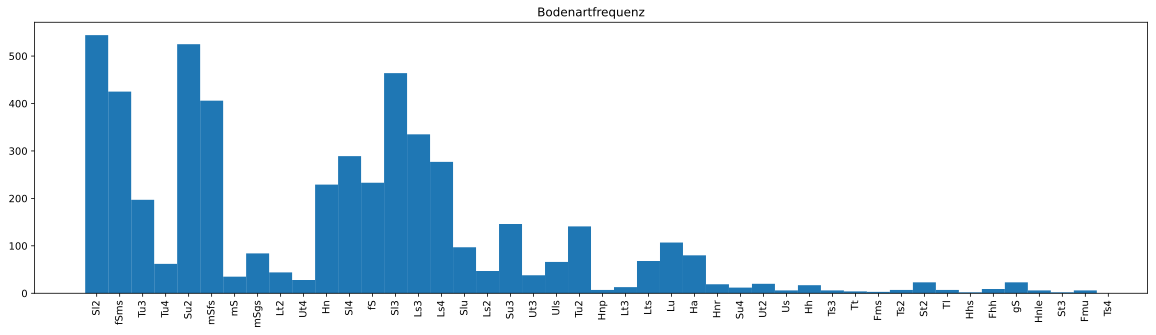

In [21]:
counts = df[label].value_counts()
plt.figure(figsize=(20, 5))
plt.hist(df[label], bins = np.arange(len(counts))-0.5)
plt.title('Bodenartfrequenz')
plt.xticks(rotation='vertical')
plt.show()

In [22]:
counts[counts<min_labels] = np.nan
bgr_data.encode_categorical_columns(df, label)
df = df.dropna(subset= feature_columns + [label])
df[label] = df[label].astype(int)

/mnt/KInsektDaten/teo/./BGR/bgr/datasets.py:34: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col_name] = df[col_name].replace(counts.index, range(len(counts)))
/mnt/KInsektDaten/teo/./BGR/bgr/datasets.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_name] = df[col_name].replace(counts.index, range(len(counts)))


In [23]:
for categ in categ_features:
    bgr_data.encode_categorical_columns(df, categ)
df

/mnt/KInsektDaten/teo/./BGR/bgr/datasets.py:34: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col_name] = df[col_name].replace(counts.index, range(len(counts)))
/mnt/KInsektDaten/teo/./BGR/bgr/datasets.py:34: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col_name] = df[col_name].replace(counts.index, range(len(counts)))
/mnt/KInsektDaten/teo/./BGR/bgr/datasets.py:34: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infe

,Point,HorizontID,Obergrenze,Untergrenze,Horizontsymbol_einfach,Bodenart,Bodenfarbe,Steine,Karbonat,Humusgehaltsklasse,Durchwurzelung,max_depth,file,Aufnehmer,Probenahme_Monat,Probenahme_Jahr,xcoord,ycoord,Bodenklimaraum_Name,Landnutzung,BZE_Moor,Hauptbodentyp,BodenVarTypSub,GrundwaStufe,GrundwaStand,Moormaechtigkeit,Torfmaechtigkeit,Neigung,Exposition,Woelbung,Reliefformtyp,LageImRelief,KV_0_30,KV_30_100
2,2.0,1.0,0.0,28.0,0,0,23,3.0,0,1,3,100.0,../data/BGR/Profilbilder_no_ruler/SH_0002_Y_1.JPG,Kart8,8,2018,484922.3074,6080011.471,41,0,0,39,235,1,105.0,0.0,0.0,0,NE,0,3,1,65.60,120.40
3,2.0,1.0,0.0,28.0,0,0,23,3.0,0,1,3,100.0,../data/BGR/Profilbilder_no_ruler/SH_0002_Y_1.JPG,Kart8,10,2015,497355.9905,6079646.589,41,1,0,9,290,1,180.0,0.0,0.0,3,SS,0,7,5,88.82,220.87
7,2.0,2.0,28.0,54.0,271,0,0,3.0,0,3,2,90.0,../data/BGR/Profilbilder_no_ruler/SH_0002_Y_1.JPG,Kart8,8,2018,484922.3074,6080011.471,41,0,0,39,235,1,105.0,0.0,0.0,0,NE,0,3,1,65.60,120.40
8,2.0,2.0,28.0,54.0,271,0,0,3.0,0,3,2,90.0,../data/BGR/Profilbilder_no_ruler/SH_0002_Y_1.JPG,Kart8,10,2015,497355.9905,6079646.589,41,1,0,9,290,1,180.0,0.0,0.0,3,SS,0,7,5,88.82,220.87
12,2.0,3.0,54.0,68.0,6,0,29,10.0,0,2,2,100.0,../data/BGR/Profilbilder_no_ruler/SH_0002_Y_1.JPG,Kart8,8,2018,484922.3074,6080011.471,41,0,0,39,235,1,105.0,0.0,0.0,0,NE,0,3,1,65.60,120.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16465,944.0,3.0,33.0,54.0,8,1,67,2.0,0,2,2,80.0,../data/BGR/Profilbilder_no_ruler/BB_0944_Y_1.JPG,Kart8,7,2014,618590.6859,5276214.216,23,1,1,30,277,2,70.0,26.0,26.0,4,NN,1,3,4,204.23,28.54
16467,944.0,3.0,33.0,54.0,8,1,67,2.0,0,2,2,80.0,../data/BGR/Profilbilder_no_ruler/BB_0944_Y_1.JPG,Kart8,11,2013,577647.0208,5268240.572,47,1,0,0,3,0,200.0,0.0,0.0,6,WW,1,0,0,87.31,34.85
16470,944.0,4.0,54.0,115.0,236,0,17,2.0,0,2,1,100.0,../data/BGR/Profilbilder_no_ruler/BB_0944_Y_1.JPG,Kart8,4,2013,584073.4145,5274336.389,23,1,0,0,0,0,200.0,0.0,0.0,10,SE,0,0,2,72.41,22.63
16471,944.0,4.0,54.0,115.0,236,0,17,2.0,0,2,1,100.0,../data/BGR/Profilbilder_no_ruler/BB_0944_Y_1.JPG,Kart8,7,2014,618590.6859,5276214.216,23,1,1,30,277,2,70.0,26.0,26.0,4,NN,1,3,4,204.23,28.54


In [24]:
# Define the image transforms (resize, normalize, etc.)
transform = transforms.Compose([
    #CenterCropTransform(240, 450), # from bgr.segmentation
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(224),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.ToTensor(),          # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize with ImageNet statistics
])

In [25]:
# Initialize model
model = bgr_mod.ImageTabularModel(vision_backbone=vision_backbone,
                                  num_tabular_features=len(feature_columns),
                                  num_classes=len(df[label].unique()))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of the model checkpoint at WinKawaks/vit-small-patch16-224 were not used when initializing ViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-small-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ImageTabularModel(
  (vision_backbone): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=384, 

In [26]:
# Data split
train_df, test_df = train_test_split(df, stratify=df['Bodenart'], random_state=2024)

print(f'{len(train_df)} samples for training.')
print(f'{len(test_df)}  samples for testing.')

3872 samples for training.
1291  samples for testing.


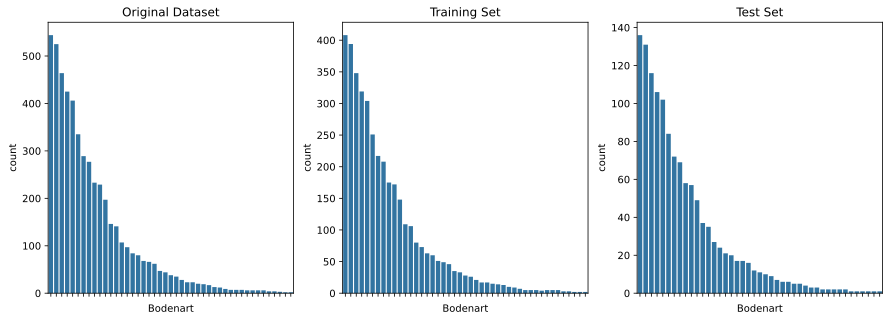

In [27]:
# Visualize the distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.countplot(x='Bodenart', data=df, ax=axes[0])
axes[0].set_title('Original Dataset'); axes[0].set_xticklabels([])

sns.countplot(x='Bodenart', data=train_df, ax=axes[1])
axes[1].set_title('Training Set'); axes[1].set_xticklabels([])

sns.countplot(x='Bodenart', data=test_df, ax=axes[2])
axes[2].set_title('Test Set'); axes[2].set_xticklabels([])

plt.show()

In [28]:
# Erstelle das Dataset mit DataFrame, Bildern und tabellarischen Daten
dataset = bgr_data.ImageTabularDataset(dataframe=train_df,#[:100],
                                       transform=transform,
                                       image_path='file',
                                       label=label,
                                       feature_columns=feature_columns)

# Erstelle den DataLoader
train_loader = DataLoader(dataset, batch_size=64,#16,
                        shuffle=True)

# Beispiel: Definiere einen Optimizer und eine Loss-Funktion
optimizer = optim.Adam(model.parameters(), lr=1e-3) #1e-4
criterion = nn.CrossEntropyLoss()

In [29]:
test_dataset = bgr_data.ImageTabularDataset(dataframe=test_df,#[:100],
                                            transform=transform,
                                            image_path='file',
                                            label=label,
                                            feature_columns=feature_columns)

# Erstelle den DataLoader
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [30]:
model.train()
for epoch in range(10):
    # Training loop
    train_correct = 0
    for batch in train_loader:
        images, tabular_features, labels = batch
        images, tabular_features, labels = images.to(device), tabular_features.to(device), labels.to(device)
        outputs = model(image=images, tabular_features=tabular_features)
        train_loss = criterion(outputs, labels)
        train_loss.backward()
        optimizer.step()

        # Calculate accuracy for this batch
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()

    # Calculate average training accuracy for the epoch
    train_acc = train_correct / len(train_loader.dataset)

    # Evaluation loop
    model.eval()
    test_correct = 0
    with torch.no_grad():
        for batch in test_loader:
            images, tabular_features, labels = batch
            images, tabular_features, labels = images.to(device), tabular_features.to(device), labels.to(device)
            outputs = model(image=images, tabular_features=tabular_features)
            test_loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            test_correct += (predicted == labels).sum().item()

    # Calculate average test accuracy for the epoch
    test_acc = test_correct / len(test_loader.dataset)

    print(f"Epoch {epoch}, Training Loss: {train_loss.item():.4f}, Training Accuracy: {train_acc:.4f}, Test Loss: {test_loss.item():.4f}, Test Accuracy: {test_acc:.4f}")

Epoch 0, Training Loss: 8.0651, Training Accuracy: 0.0457, Test Loss: 3.9797, Test Accuracy: 0.0302
Epoch 1, Training Loss: 3.7336, Training Accuracy: 0.0413, Test Loss: 3.6933, Test Accuracy: 0.0093
Epoch 2, Training Loss: 3.6358, Training Accuracy: 0.0943, Test Loss: 3.6061, Test Accuracy: 0.1053
Epoch 3, Training Loss: 3.5801, Training Accuracy: 0.1054, Test Loss: 3.4530, Test Accuracy: 0.1053
Epoch 4, Training Loss: 3.5238, Training Accuracy: 0.1054, Test Loss: 3.4895, Test Accuracy: 0.1053
Epoch 5, Training Loss: 3.5290, Training Accuracy: 0.1054, Test Loss: 3.3958, Test Accuracy: 0.1053
Epoch 6, Training Loss: 3.1431, Training Accuracy: 0.1054, Test Loss: 3.3714, Test Accuracy: 0.1053
Epoch 7, Training Loss: 3.2103, Training Accuracy: 0.1054, Test Loss: 3.2201, Test Accuracy: 0.1053
Epoch 8, Training Loss: 3.2190, Training Accuracy: 0.1054, Test Loss: 3.1201, Test Accuracy: 0.1053
Epoch 9, Training Loss: 3.0421, Training Accuracy: 0.1054, Test Loss: 3.4590, Test Accuracy: 0.1053


In [31]:
model.eval()  # Setze das Modell in den Evaluierungsmodus
with torch.no_grad():
    outputs = []
    for batch in test_loader:
        images, tabular_features, labels = batch
        images, tabular_features, labels = images.to(device), tabular_features.to(device), labels.to(device)
        outputs.append(model(image=images, tabular_features=tabular_features))

In [32]:
from sklearn.metrics import classification_report, confusion_matrix

# Convert outputs to predicted labels (adjust based on your model's output format)
predicted_labels = []
for output in outputs:
    # Apply threshold or use appropriate function to get predicted labels
    predicted_labels.extend(torch.argmax(output, dim=1).tolist())

# Convert true labels to a list
true_labels = [label.item() for batch in test_loader for label in batch[2]]

# Calculate metrics
report = classification_report(true_labels, predicted_labels)
print(report)

              precision    recall  f1-score   support

           0       0.11      1.00      0.19       136
           1       0.00      0.00      0.00       131
           2       0.00      0.00      0.00       116
           3       0.00      0.00      0.00       106
           4       0.00      0.00      0.00       102
           5       0.00      0.00      0.00        84
           6       0.00      0.00      0.00        72
           7       0.00      0.00      0.00        69
           8       0.00      0.00      0.00        58
           9       0.00      0.00      0.00        57
          10       0.00      0.00      0.00        49
          11       0.00      0.00      0.00        37
          12       0.00      0.00      0.00        35
          13       0.00      0.00      0.00        27
          14       0.00      0.00      0.00        24
          15       0.00      0.00      0.00        21
          16       0.00      0.00      0.00        20
          17       0.00    

/home/tchiaburu/anaconda3/envs/torch_gpu_sam/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tchiaburu/anaconda3/envs/torch_gpu_sam/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tchiaburu/anaconda3/envs/torch_gpu_sam/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

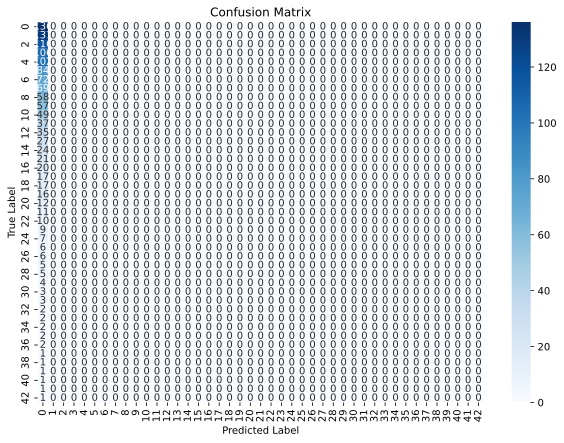

In [33]:
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [34]:
"""
# TODO
from transformers import TrainingArguments, Trainer

# Define training arguments
training_args = TrainingArguments(
    output_dir="./testtest",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    evaluation_strategy="epoch",
    num_train_epochs=53,
    logging_dir="./logs",
    logging_steps=10,
    save_steps=1000,
    learning_rate=5e-5,
    weight_decay=0.01,
    report_to="none",  # Set to "wandb" or other service if tracking experiments
)

# Initialize the Trainer with the model, data, and training arguments
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=collate_fn,
)

# Train the model
trainer.train()

# Evaluate the model on the test dataset
eval_results = trainer.evaluate()
print(f"Test Accuracy: {eval_results['eval_accuracy']}")
"""

'\n# TODO\nfrom transformers import TrainingArguments, Trainer\n\n# Define training arguments\ntraining_args = TrainingArguments(\n    output_dir="./testtest",\n    per_device_train_batch_size=32,\n    per_device_eval_batch_size=32,\n    evaluation_strategy="epoch",\n    num_train_epochs=53,\n    logging_dir="./logs",\n    logging_steps=10,\n    save_steps=1000,\n    learning_rate=5e-5,\n    weight_decay=0.01,\n    report_to="none",  # Set to "wandb" or other service if tracking experiments\n)\n\n# Initialize the Trainer with the model, data, and training arguments\ntrainer = Trainer(\n    model=model,\n    args=training_args,\n    train_dataset=train_dataset,\n    eval_dataset=test_dataset,\n    data_collator=collate_fn,\n)\n\n# Train the model\ntrainer.train()\n\n# Evaluate the model on the test dataset\neval_results = trainer.evaluate()\nprint(f"Test Accuracy: {eval_results[\'eval_accuracy\']}")\n'